<a href="https://colab.research.google.com/github/sara-ghavampour/rl_a3/blob/main/RL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
random.seed(123)


In [ ]:
reds=[(2,0),(2,1),(2,3),(2,4)]
blacks=[(0,0),(0,4)]
blue=(4,0)

#Change from (row,column) form to single index from 0 to 24 that starts at TOP LEFT and ends at BOTTOM RIGHT
rc_to_index=lambda r, c: r * 5 + c
index_to_rc=lambda s: divmod(s, 5)

blue_index=rc_to_index(*blue)
red_index = [rc_to_index(r, c) for (r, c) in reds]
black_index = [rc_to_index(r, c) for (r, c) in blacks]

actions   = [0, 1, 2, 3]      # 0=Up, 1=Right, 2=Down, 3=Left
move_row  = [-1,  0, +1,  0]
move_col  = [ 0, +1,  0, -1]

In [ ]:
def step(state, action):



    if state in black_index:
        return state, 0.0, True

    # agent starts again in blue after hitting the red states
    if state in red_index:
        return blue_index, -20, False



    # Ordinary move or wall bump
    r, c = index_to_rc(state)
    nr, nc = r + move_row[action], c + move_col[action]

    if not (0 <= nr < 5 and 0 <= nc < 5):
        return state, -1, False

    next_state = rc_to_index(nr, nc)
    reward =-1
    done = next_state in blacks
    return next_state, reward, done

In [ ]:
def init_tables():
    #initialised q values and numbver of visits to (s,a) pairs and optimal policy to zeros
    Q  = [[0.0 for _ in actions] for _ in range(5* 5)] #Q[state][action] action value
    N  = [[0   for _ in actions] for _ in range(5 * 5)] # visits
    pi = [-1 for _ in range(5* 5)]               #-1=unkonwn, pi[state] is best policy at that state, found from max Q
    return Q, N, pi
def best_action(Q_row):
    max_q = max(Q_row)
    best_as = [a for a, q in enumerate(Q_row) if q == max_q]
    return random.choice(best_as)

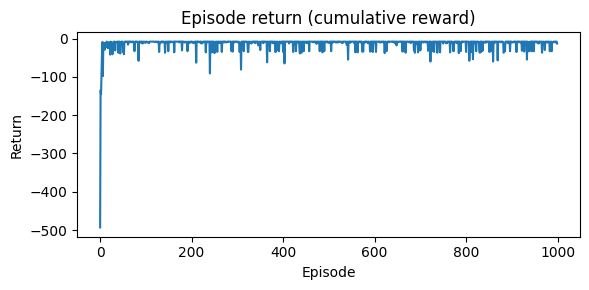

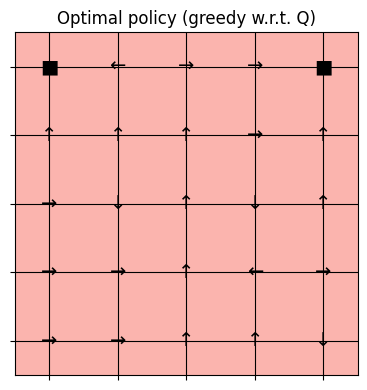

In [ ]:
import random
import matplotlib.pyplot as plt
random.seed(123)



def epsilon_greedy(Q_row, epsilon):
    if random.random() < epsilon:
        return random.choice(actions)
    return best_action(Q_row)


# Q-learning
def train_q_learning(
        episodes=1000,
        gamma=0.95,
        eps_start=0.1,
        eps_min=0.1,
        eps_decay=1
):
    Q, N, PI = init_tables()
    epsilon   = eps_start
    ep_returns = []                        # reward per episode

    for _ in range(episodes):
        state   = blue_index
        done    = False
        G       = 0                        # accumulate reward this episode

        while not done:
            action = epsilon_greedy(Q[state], epsilon)
            next_state, reward, done = step(state, action)

            # decaying learning-rate: α = 1 / visits
            N[state][action] += 1
            # alpha = 1.0 / N[state][action]
            alpha = 0.5

            td_target = reward + gamma * max(Q[next_state])
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            G    += reward

        ep_returns.append(G)
        epsilon = max(eps_min, epsilon * eps_decay)

    # derive deterministic policy
    for s in range(25):
        PI[s] = -1 if s in black_index else best_action(Q[s])

    return Q, PI, ep_returns


#help functions

arrow = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: '■'}  # -1 for walls/terminal

def plot_episode_returns(returns):
    plt.figure(figsize=(6, 3))
    plt.plot(returns)
    plt.title("Episode return (cumulative reward)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.tight_layout()
    plt.show()

def plot_policy(PI):
    grid = [[PI[rc_to_index(r, c)] for c in range(5)] for r in range(5)]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow([[0]*5 for _ in range(5)], cmap='Pastel1', vmin=0, vmax=1)  # blank grid

    # draw symbols
    for r in range(5):
        for c in range(5):
            idx = rc_to_index(r, c)
            txt = arrow[ -1 if idx in black_index else PI[idx] ]
            ax.text(c, r, txt, ha='center', va='center', fontsize=14)

    ax.set_xticks(range(5)); ax.set_yticks(range(5))
    ax.set_xticklabels([]);  ax.set_yticklabels([])
    ax.set_title("Optimal policy (greedy w.r.t. Q)")
    ax.grid(color='black')
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    Qq, PIq, ep_returnsq = train_q_learning()

    plot_episode_returns(ep_returnsq)

    plot_policy(PIq)

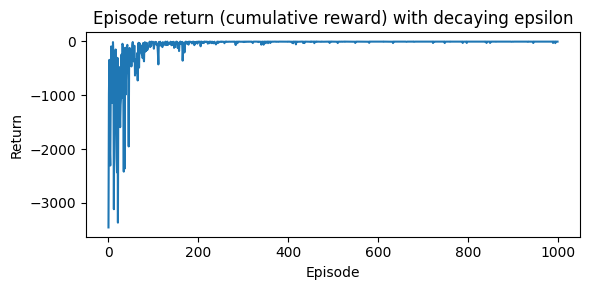

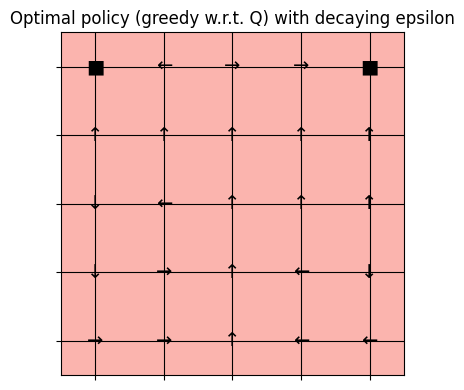

In [ ]:



# SARSA
def train_sarsa(
        episodes=1000,
        gamma=0.95,
        eps_start=1.0,
        eps_min=0.05,
        eps_decay=0.995


):
    Q, N, PI = init_tables()
    epsilon   = eps_start
    ep_returns = []

    for _ in range(episodes):
        state   = blue_index
        action  = epsilon_greedy(Q[state], epsilon)
        done    = False
        G       = 0

        while not done:
            next_state, reward, done = step(state, action)
            N[state][action] += 1
            # alpha = 1.0 / N[state][action]
            alpha = 0.1

            if done:
                td_target = reward                       # terminal bootstrap
                Q[state][action] += alpha * (td_target - Q[state][action])
                G += reward
                break

            next_action = epsilon_greedy(Q[next_state], epsilon)
            td_target   = reward + gamma * Q[next_state][next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state, action = next_state, next_action
            G += reward

        ep_returns.append(G)
        epsilon = max(eps_min, epsilon * eps_decay)

    # derive deterministic policy
    for s in range(25):
        PI[s] = -1 if s in black_index else best_action(Q[s])
    return Q, PI, ep_returns


# Plot

arrow = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: '■'}

def plot_episode_returns(returns):
    plt.figure(figsize=(6, 3))
    plt.plot(returns)
    plt.title("Episode return (cumulative reward) with decaying epsilon")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.tight_layout(); plt.show()

def plot_policy(PI):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow([[0]*5 for _ in range(5)], cmap='Pastel1', vmin=0, vmax=1)

    for r in range(5):
        for c in range(5):
            idx = rc_to_index(r, c)
            txt = arrow[-1 if idx in black_index else PI[idx]]
            ax.text(c, r, txt, ha='center', va='center', fontsize=14)

    ax.set_xticks(range(5)); ax.set_yticks(range(5))
    ax.set_xticklabels([]);  ax.set_yticklabels([])
    ax.set_title("Optimal policy (greedy w.r.t. Q) with decaying epsilon")
    ax.grid(color='black')
    plt.tight_layout(); plt.show()



if __name__ == "__main__":
    Qs, PIs, ep_returnss = train_sarsa()

    plot_episode_returns(ep_returnss)   # reward curve
    plot_policy(PIs)                    # arrow diagram of policy


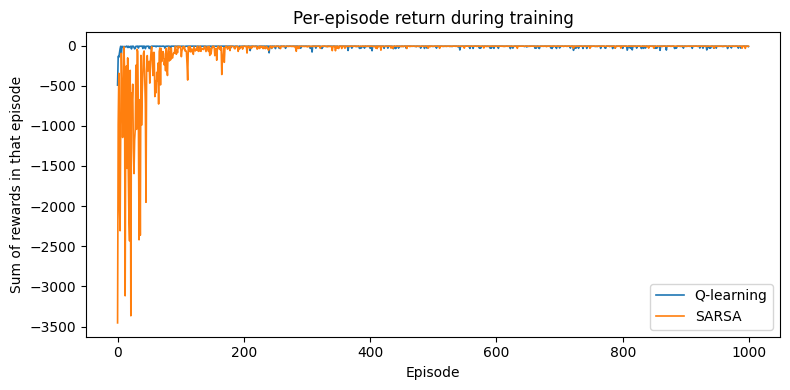

In [ ]:
# compare q learning and arsa together
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(ep_returnsq, label="Q-learning",  linewidth=1.2)
plt.plot(ep_returnss, label="SARSA",       linewidth=1.2)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards in that episode")
plt.title("Per-episode return during training")
plt.legend()
plt.tight_layout()
plt.show()


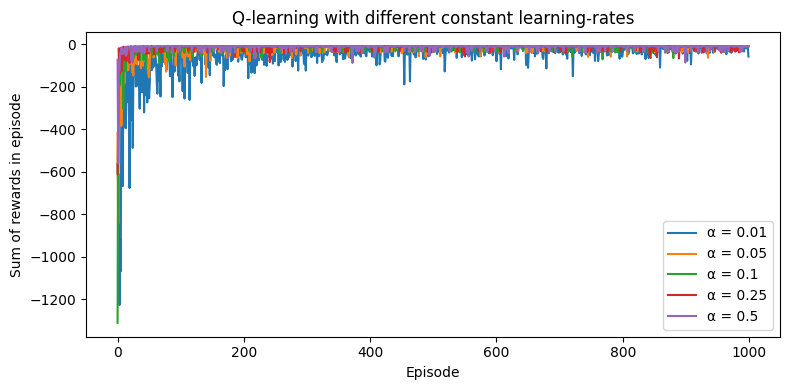

In [ ]:
import random, matplotlib.pyplot as plt

# plot q learning qith different alphas
def train_q_learning_const_alpha(
        alpha,
        episodes=1000,
        gamma=0.95,
        eps_start=0.1,
        eps_min=0.1,
        eps_decay=1,
):
    Q, _, _      = init_tables()
    epsilon       = eps_start
    ep_returns    = []

    for _ in range(episodes):
        state = blue_index            # always start at the blue square
        G     = 0
        done  = False

        while not done:
            action = epsilon_greedy(Q[state], epsilon)
            next_state, reward, done = step(state, action)

            td_target = reward + gamma * max(Q[next_state])
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            G    += reward

        ep_returns.append(G)
        epsilon = max(eps_min, epsilon * eps_decay)

    return ep_returns


alphas = [0.01, 0.05, 0.10, 0.25, 0.50]
results = {a: train_q_learning_const_alpha(a) for a in alphas}

# plot

plt.figure(figsize=(8, 4))
for a, returns in results.items():
    plt.plot(returns, label=f"α = {a}")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards in episode")
plt.title("Q-learning with different constant learning-rates")
plt.legend()
plt.tight_layout()
plt.show()


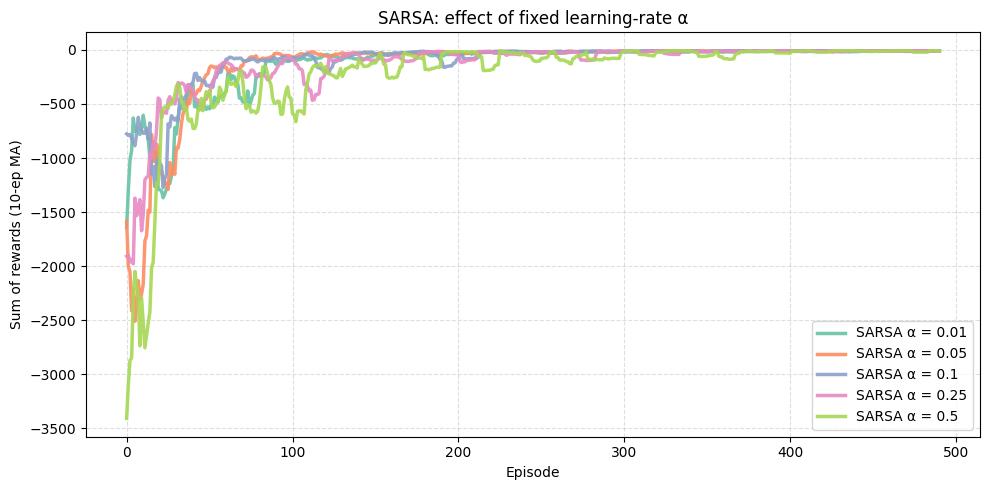

In [ ]:
import random, itertools, numpy as np, matplotlib.pyplot as plt

# plot sarsa qith different alphas

def train_sarsa_const_alpha(
        alpha,
        episodes=500,
        gamma=0.95,
        eps_start=1.0,
        eps_min=0.05,
        eps_decay=0.995,
):
    Q, _, _ = init_tables()
    epsilon = eps_start
    returns = []

    for _ in range(episodes):
        state  = blue_index         # fixed start on the blue square
        action = epsilon_greedy(Q[state], epsilon)
        G      = 0
        done   = False

        while not done:
            next_state, reward, done = step(state, action)
            G += reward

            if done:
                # terminal bootstrap
                Q[state][action] += alpha * (reward - Q[state][action])
                break

            next_action = epsilon_greedy(Q[next_state], epsilon)
            td_target   = reward + gamma * Q[next_state][next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state, action = next_state, next_action

        returns.append(G)
        epsilon = max(eps_min, epsilon * eps_decay)

    return returns



alphas        = [0.01, 0.05, 0.10, 0.25, 0.50]
sarsa_results = {a: train_sarsa_const_alpha(a) for a in alphas}


# to have more clear curves
def smooth(y, k=10):
    if k <= 1:
        return y
    return np.convolve(y, np.ones(k) / k, mode="valid")

# plot

plt.figure(figsize=(10, 5))
colour_cycle = itertools.cycle(plt.cm.Set2.colors)   # bright, distinct colours

for a in alphas:
    colour   = next(colour_cycle)
    curve    = smooth(sarsa_results[a], k=10)        # 10-episode moving avg
    episodes = range(len(curve))
    plt.plot(episodes, curve,
             label=f"SARSA α = {a}",
             color=colour,
             linewidth=2.5,
             alpha=0.9)

plt.xlabel("Episode")
plt.ylabel("Sum of rewards (10-ep MA)")
plt.title("SARSA: effect of fixed learning-rate α")
plt.grid(ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


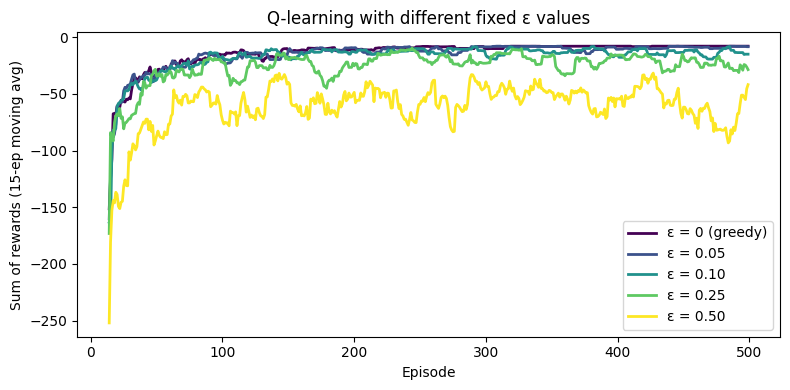

In [ ]:

import random, matplotlib.pyplot as plt, numpy as np


# plot sarsa qith different epsilons

def train_q_learning_fixed_eps(
        epsilon,
        alpha=0.1,
        episodes=500,
        gamma=0.95,
):
    Q, _, _    = init_tables()
    returns     = []

    for _ in range(episodes):
        state, G, done = blue_index, 0, False

        while not done:
            a  = epsilon_greedy(Q[state], epsilon)
            s2, r, done = step(state, a)

            td_target = r + gamma * max(Q[s2])
            Q[state][a] += alpha * (td_target - Q[state][a])

            state, G = s2, G + r

        returns.append(G)
    return returns


# more clear vurves
def moving_avg(x, k=15):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[k:] - cumsum[:-k]) / k



epsilons   = [0.00, 0.05, 0.10, 0.25, 0.50]
colors     = plt.cm.viridis(np.linspace(0, 1, len(epsilons)))
episodes   = 500
window     = 15                                  # smoothing window

plt.figure(figsize=(8, 4))

for eps, col in zip(epsilons, colors):
    raw = train_q_learning_fixed_eps(eps, episodes=episodes)
    sm  = moving_avg(raw, k=window)
    x   = range(window-1, episodes)               # align smoothed curve
    label = "ε = 0 (greedy)" if eps == 0 else f"ε = {eps:.2f}"
    plt.plot(x, sm, color=col, linewidth=2, label=label)

plt.xlabel("Episode")
plt.ylabel("Sum of rewards ({}-ep moving avg)".format(window))
plt.title("Q-learning with different fixed ε values")
plt.legend()
plt.tight_layout()
plt.show()

